In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

(high-dim-data)=
# High Dimensional Data

Working with data that has more than 3 dimensions can be challenging. We live in a 3-dimensional world, our brains have evolved to think intuitively in 3 dimensions, making it relatively easy to visualize 3-dimensional data and gain good intuition about it. However, when working with data the number of dimensions can be much, much higher. This means new techniques and concepts are needed to make sense of these complex datasets.

## High Dimensional Dataset Examples

In this module we will work with 2 high-dimensional datasets: the Dow dataset that you have already seen (40 dimensions), and a new "toy" dataset of hand-written digits (64 dimensions).

### Dow Dataset

We can read in the Dow dataset below. By this point, this block should be familiar.

In [3]:
import pandas as pd

df = pd.read_excel('data/impurity_dataset-training.xlsx')
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)
print(X_dow.shape, y_dow.shape)

(10297, 40) (10297, 1)


There are 10,297 entries in this dataset, each of which has 40 process variables that describe it, and a corresponding continuous output (impurity level). We have worked with this before as a regression problem, but in this module we will focus solely on the feature matrix, $X$.

### MNIST Dataset

The MNIST dataset is one of the most famous "toy" datasets in machine learning. The dataset consists of images of hand-written numbers from 0-9. There are several variants, and the one we will use here is built into scikit-learn and has lower resolution digits compared to the original MNIST set.

In [4]:
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


We have 1,797 examples of digits, and each image has been "unraveled" into a 64-dimensional vector. If we want to see the digits we can re-organize the 64 dimensions into an 8x8 grid of pixels:

Digit: 9, Min: 0.0, Max: 16.0


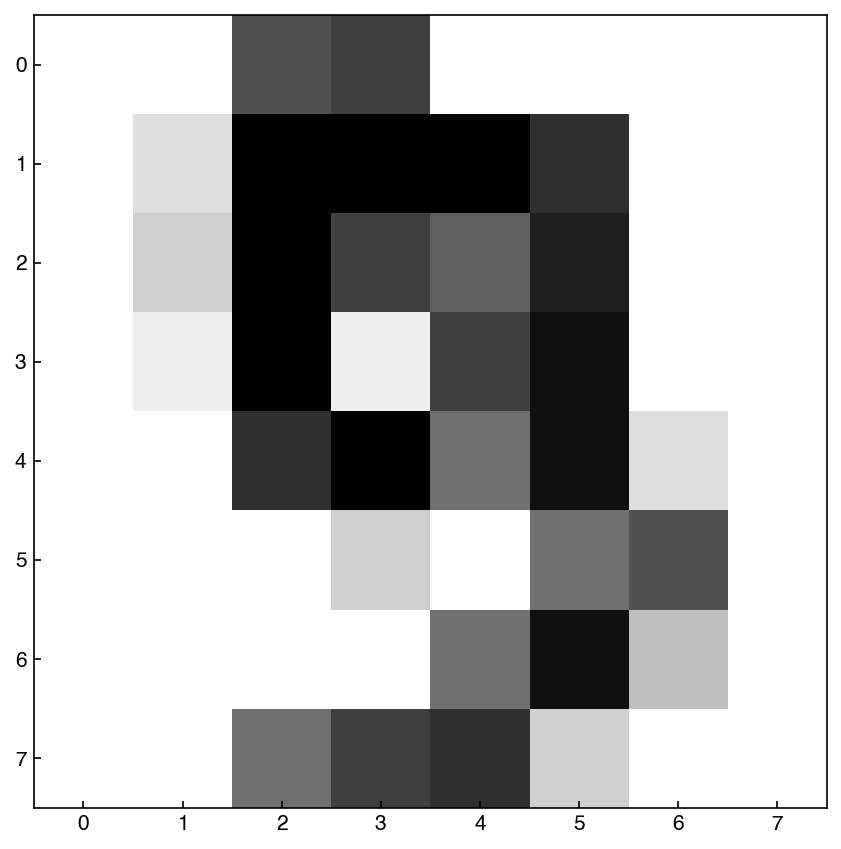

In [5]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    ax.imshow(img, cmap='binary', vmin=0, vmax=16)
    
n = 9
show_image(X_mnist, n)
print('Digit: {}, Min: {}, Max: {}'.format(y_mnist[n],X_mnist.min(),X_mnist.max()))

In this case we see that the "features" have a different meaning, and are literally directly encoding the digit. We will often move back and forth between the "vector" view (a 64-dimensional vector) and the "image" view (an 8x8 image), but the data is the same. We will also assume that each pixel is independent for now, and does not account for it's neighbors, but we will revisit this assumption when we discuss feature engineering.

## The Curse and the Blessing of Dimensionality

Dimensionality in mathematics is different from the dimensionality of the physical world. Engineers typically consider problems in 3 dimensions, but in data science the number of dimensions is equal to the number of features and can be extremely high (>10k). This leads to two phenomena:

The *curse of dimensionality* refers to the fact that the volume of a high-dimensional space varies exponentially with the dimension. For example, consider the volume of a cube of length $L$ in dimension $d$:

$V_d = L^d$

If we want to sample this space with a resolution of $\Delta L = L/N$ we would need a total of $N^d$ points. If $N=10$ and $d=100$ (a moderate number of dimensions in data science) then the total number of samples needed is $10^{100}$, which is greater than the number of atoms in the known universe!

The blessing of dimensionality is a somewhat lesser known phenomenon that occurs because of the data sparsity that arises from the curse of dimensionality. It essentially means that as the number of independent dimensions increases the data tends to be more easily separable and will look increasingly like well-separated points. This makes the data more well-suited to simplistic statistical assumptions such as being represented by a Gaussian distribution with equal covariance. One way of thinking about this is that as the volume of the space increases, the average distance between points in that space will also increase. Therefore, as more dimensions are added data points become more well-separated. 

The curse of dimensionality always applies, but the blessing is not guaranteed. This means that in general it is more challenging to work in high dimensions.

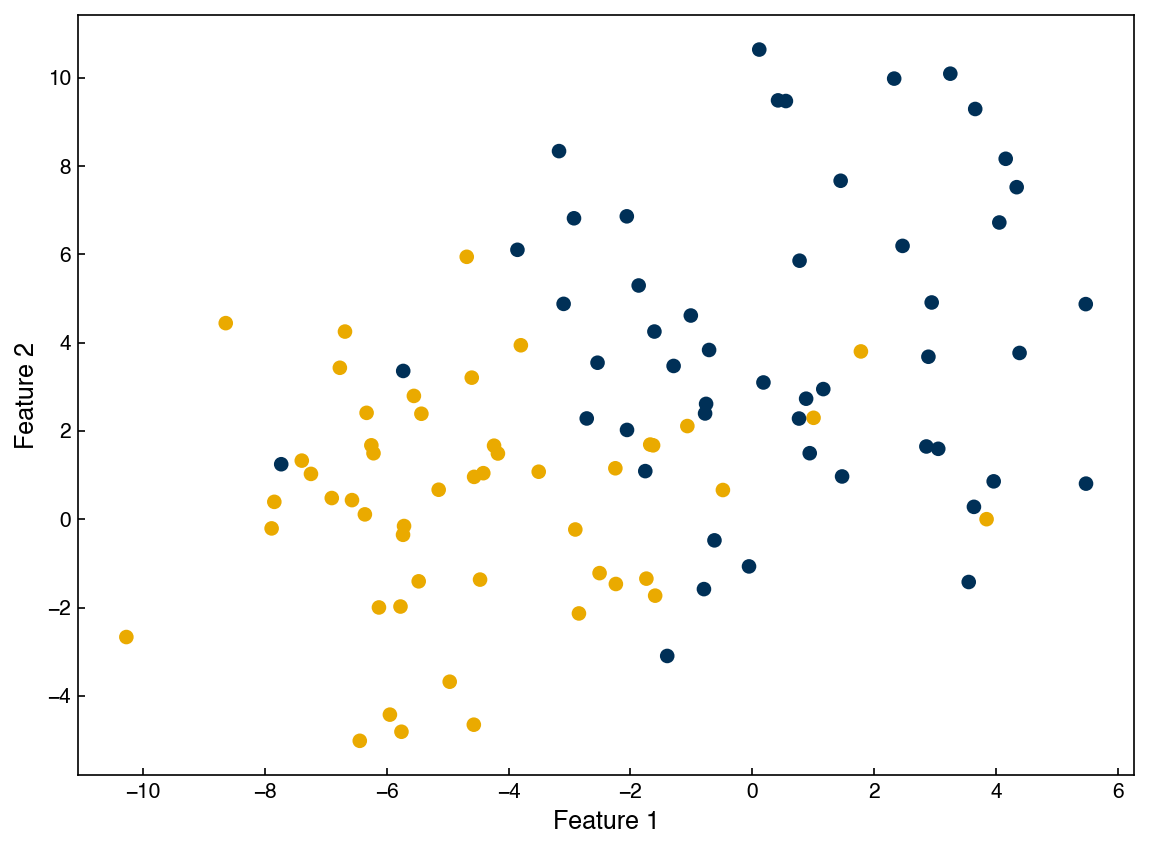

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

X, y = make_blobs(100, 2, centers = 2, cluster_std = 3.0, random_state = 3)
z = np.zeros((X.shape[0], 1))

for i, label in enumerate(y):
    z[i, 0] = np.random.normal(label * 2, 0.3, 1)

X = np.append(X, z, axis = 1)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c = clrs[y])
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2');

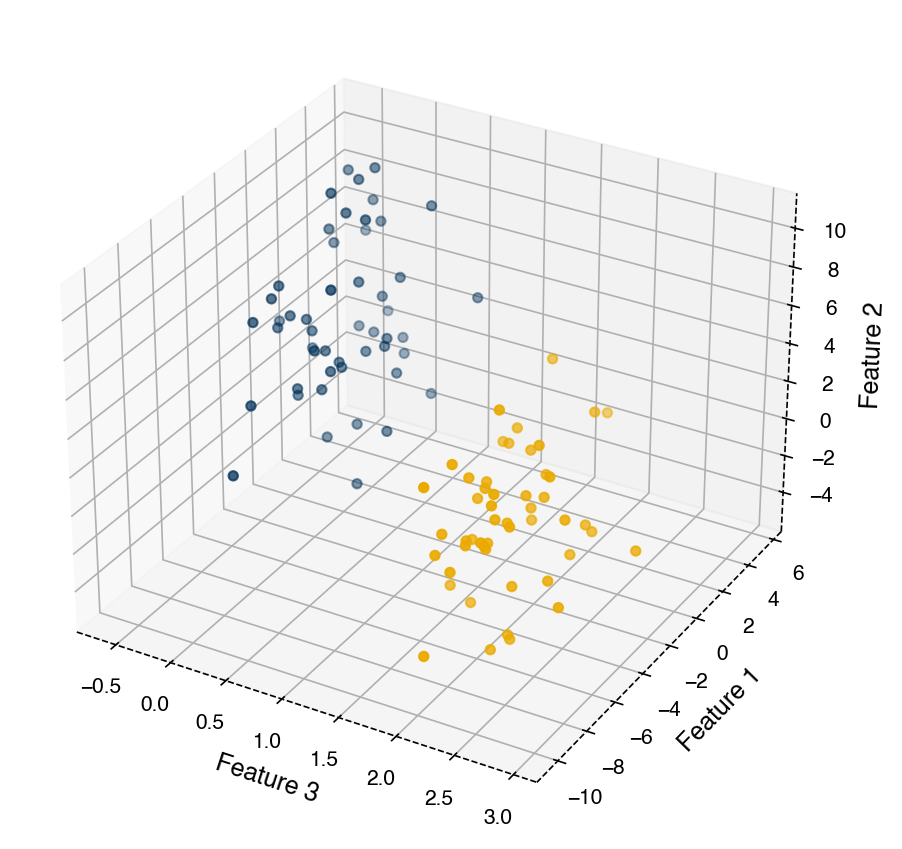

In [7]:
fig, ax = plt.subplots()
ax = plt.axes(projection = '3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c = clrs[y])
ax.set_xlabel('Feature 3')
ax.set_ylabel('Feature 1')
ax.set_zlabel('Feature 2')

plt.tight_layout();

## Inspecting High Dimensional Features

Unlike a 1-d or 2-d dataset, we cannot simply plot a high dimensional dataset. However, some visual analysis is still important.

### Summary Statistics

One of the simplest things we can do is check the "summary statistics" (mean, standard deviation, min, max, etc.) of each feature. This can be easily achieved with `numpy`. Let's take a look at the MNIST dataset first, since we haven't seen it before.

In [8]:
means = X_mnist.mean(axis=0)
print(means.shape)

(64,)


Here we have a 64-dimensional vector corresponding to the average at each pixel. Let's visualize it as an image:

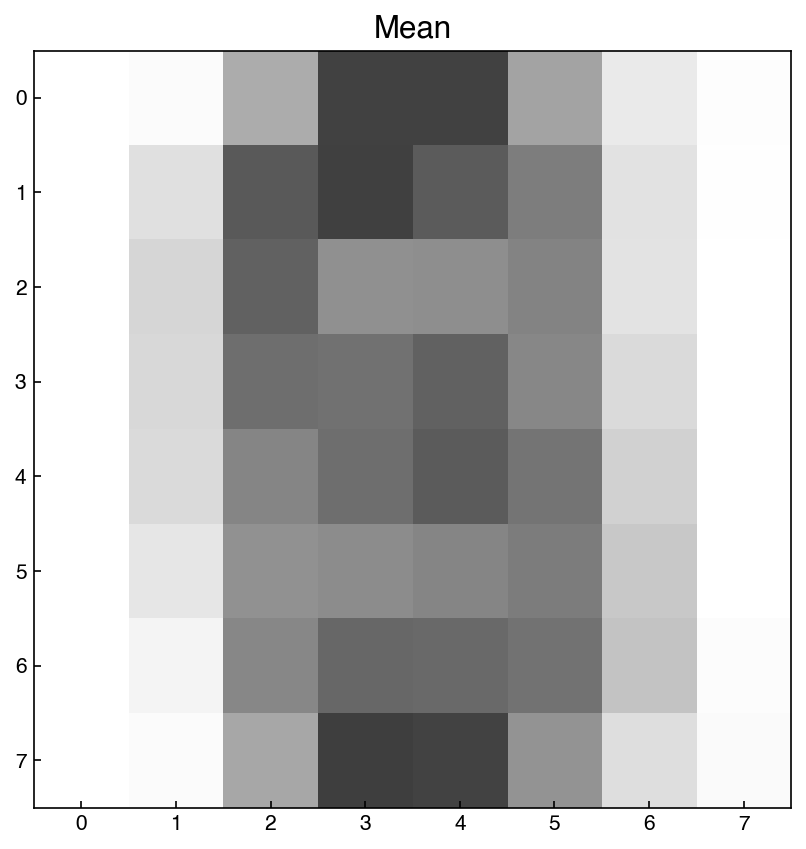

In [9]:
means = means.reshape(1,-1) #convert to *row* vector
show_image(means, 0)
plt.title('Mean');

Note that we first had to convert this to a *row* vector, so that `show_image` knows it is a single image. This tells us that the average values are highest near the center of the image, which is not surprising since all the digits are centered.

We can do the same with other summary statistics like standard deviation:

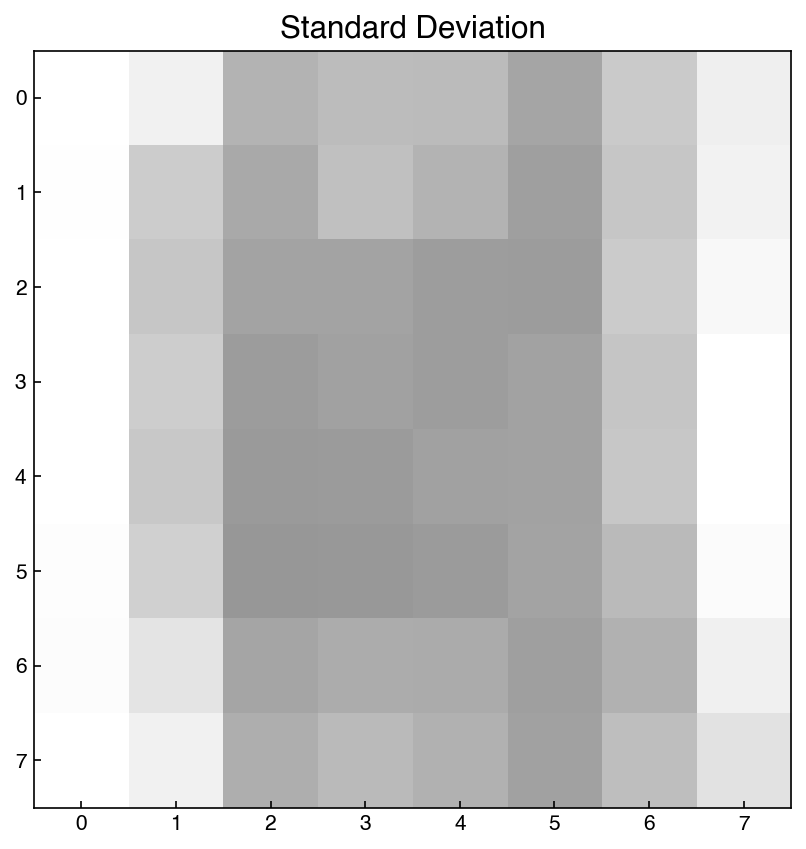

In [10]:
stdevs = X_mnist.std(axis=0).reshape(1, -1)
show_image(stdevs, 0)
plt.title('Standard Deviation');

Similarly, we see that the standard deviation is largest near the middle, though some of the edge/corner pixels also have large deviations. We could also look at the maximum:

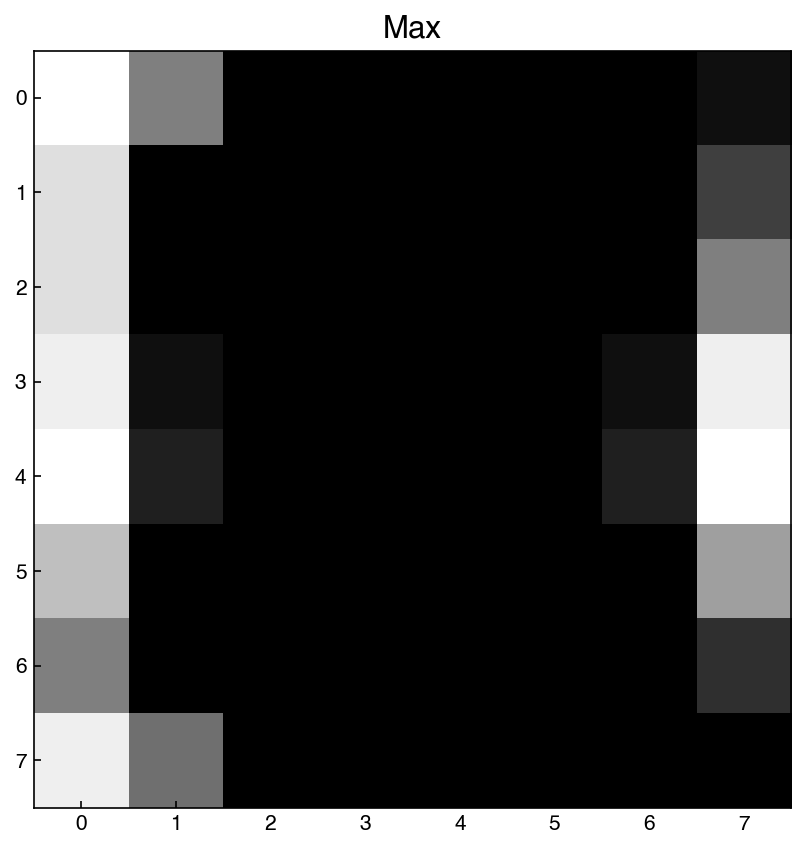

In [11]:
stdevs = X_mnist.max(axis=0).reshape(1, -1)
show_image(stdevs, 0)
plt.title('Max');

Here we see that there are some pixels where the maximum is very close to zero. This means these pixels are essentially never used. We will come back to this later.

### Example: Compute the mean and standard deviation of each feature in the Dow dataset.

In [12]:
means = X_dow.mean(axis = 0)
stds = X_dow.std(axis = 0)

data = pd.DataFrame(means, index = df.columns[1:-5], columns = ['mean'])
data['std'] = stds
data

mean         std
x1:Primary Column Reflux Flow                   363.769474   75.648106
x2:Primary Column Tails Flow                     48.042734    8.343551
x3:Input to Primary Column Bed 3 Flow          2531.650693  571.295049
x4:Input to Primary Column Bed 2 Flow          2462.787740  503.647057
x5:Primary Column Feed Flow from Feed Column    111.401576   27.229915
x6:Primary Column Make Flow                     105.252978   28.085373
x7:Primary Column Base Level                     54.301929    9.014898
x8:Primary Column Reflux Drum Pressure           39.617144    4.617643
x9:Primary Column Condenser Reflux Drum Level    52.161516    8.889529
x10:Primary Column Bed1 DP                       10.620064    3.790575
x11:Primary Column Bed2 DP                       15.297826    5.376748
x12:Primary Column Bed3 DP                       11.760801    4.500018
x13:Primary Column Bed4 DP                       11.422103    4.693002
x14:Primary Column Base Pressure                 41.672023    4.976839
x15:Primary Column Head Pressure                 39.819512    4.684090
x16:Primary Column Tails Temperature             36.284512   15.713857
x17:Primary Column Tails Temperature 1           37.060650   14.613390
x18:Primary Column Bed 4 Temperature             48.317231    4.754447
x19:Primary Column Bed 3 Temperature             48.518271    4.810075
x20:Primary Column Bed 2 Temperature             50.014718    4.894118
x21:Primary Column Bed 1 Temperature             50.912289    4.940277
x22: Secondary Column Base Concentration          0.038943    0.147693
x23: Flow from Input to Secondary Column       1887.386387  452.475951
x24: Secondary Column Tails Flow                 11.605942    2.264677
x25: Secondary Column Tray DP                     5.788218    1.313940
x26: Secondary Column Head Pressure              42.297118    5.018735
x27: Secondary Column Base Pressure              43.261101    5.140908
x28: Secondary Column Base Temperature          138.144429   21.295254
x29: Secondary Column Tray 3 Temperature         64.335413   10.438166
x30: Secondary Column Bed 1 Temperature          57.554801    7.378714
x31: Secondary Column Bed 2 Temperature          55.752824    6.700494
x32: Secondary Column Tray 2 Temperature         82.839195   18.303496
x33: Secondary Column Tray 1 Temperature        103.999019   18.989058
x34: Secondary Column Tails Temperature         138.420756   18.883768
x35: Secondary Column Tails Concentration         0.015137    0.025845
x36: Feed Column Recycle Flow                    62.291409    3.291106
x37: Feed Column Tails Flow to Primary Column    45.007949    0.001319
x38: Feed Column Calculated DP                   66.466772   15.048953
x39: Feed Column Steam Flow                       8.318070    1.788862
x40: Feed Column Tails Flow                     113.176332   27.190984

Summary statistics can give some insight into high-dimensional features by determining whether feature re-scaling is likely necessary, or whether some features do not contain information (for example, if the standard deviation is zero). However, it can still be hard to interpret these statistics, and they may not be meaningful if features do not follow a normal distribution.

### Histogram Plots

Another approach is to simply plot the 1-dimensional histograms of all the data. We have done this before with the Dow dataset, but let's take a look at the MNIST dataset:

In [13]:
N = X_mnist.shape[-1]
n = int(np.sqrt(N)) #n = 8 here
fig, axes = plt.subplots(n, n, figsize = (5 * n, 5 * n), dpi = 200)
ax_list = axes.ravel()
for i in range(N):
    ax_list[i].hist(X_mnist[:, i])
    ax_list[i].set_xlabel(i)

We can think of each plot in this matrix as corresponding to the pixel position in the image, and we are looking at a histogram of the pixel values.

### Discussion: Do these features follow a normal distribution?
> None of features follow a normal distribution.

## Scatter Plots

The histograms give more insight into the distribution of each feature, but they don't give any insight into how the features are related to each other. For this, we can use "scatter plots" of features against each other. This is often achieved with a scatter plot matrix. However, this matrix can become very large for data with dimensions >10 or so. The reason is that it will be an `n_dimensions` x `n_dimensions` matrix of plots. In the case of the MNIST dataset this would be 64x64, or 4096 total plots! Let's just look at a few features at a time instead:

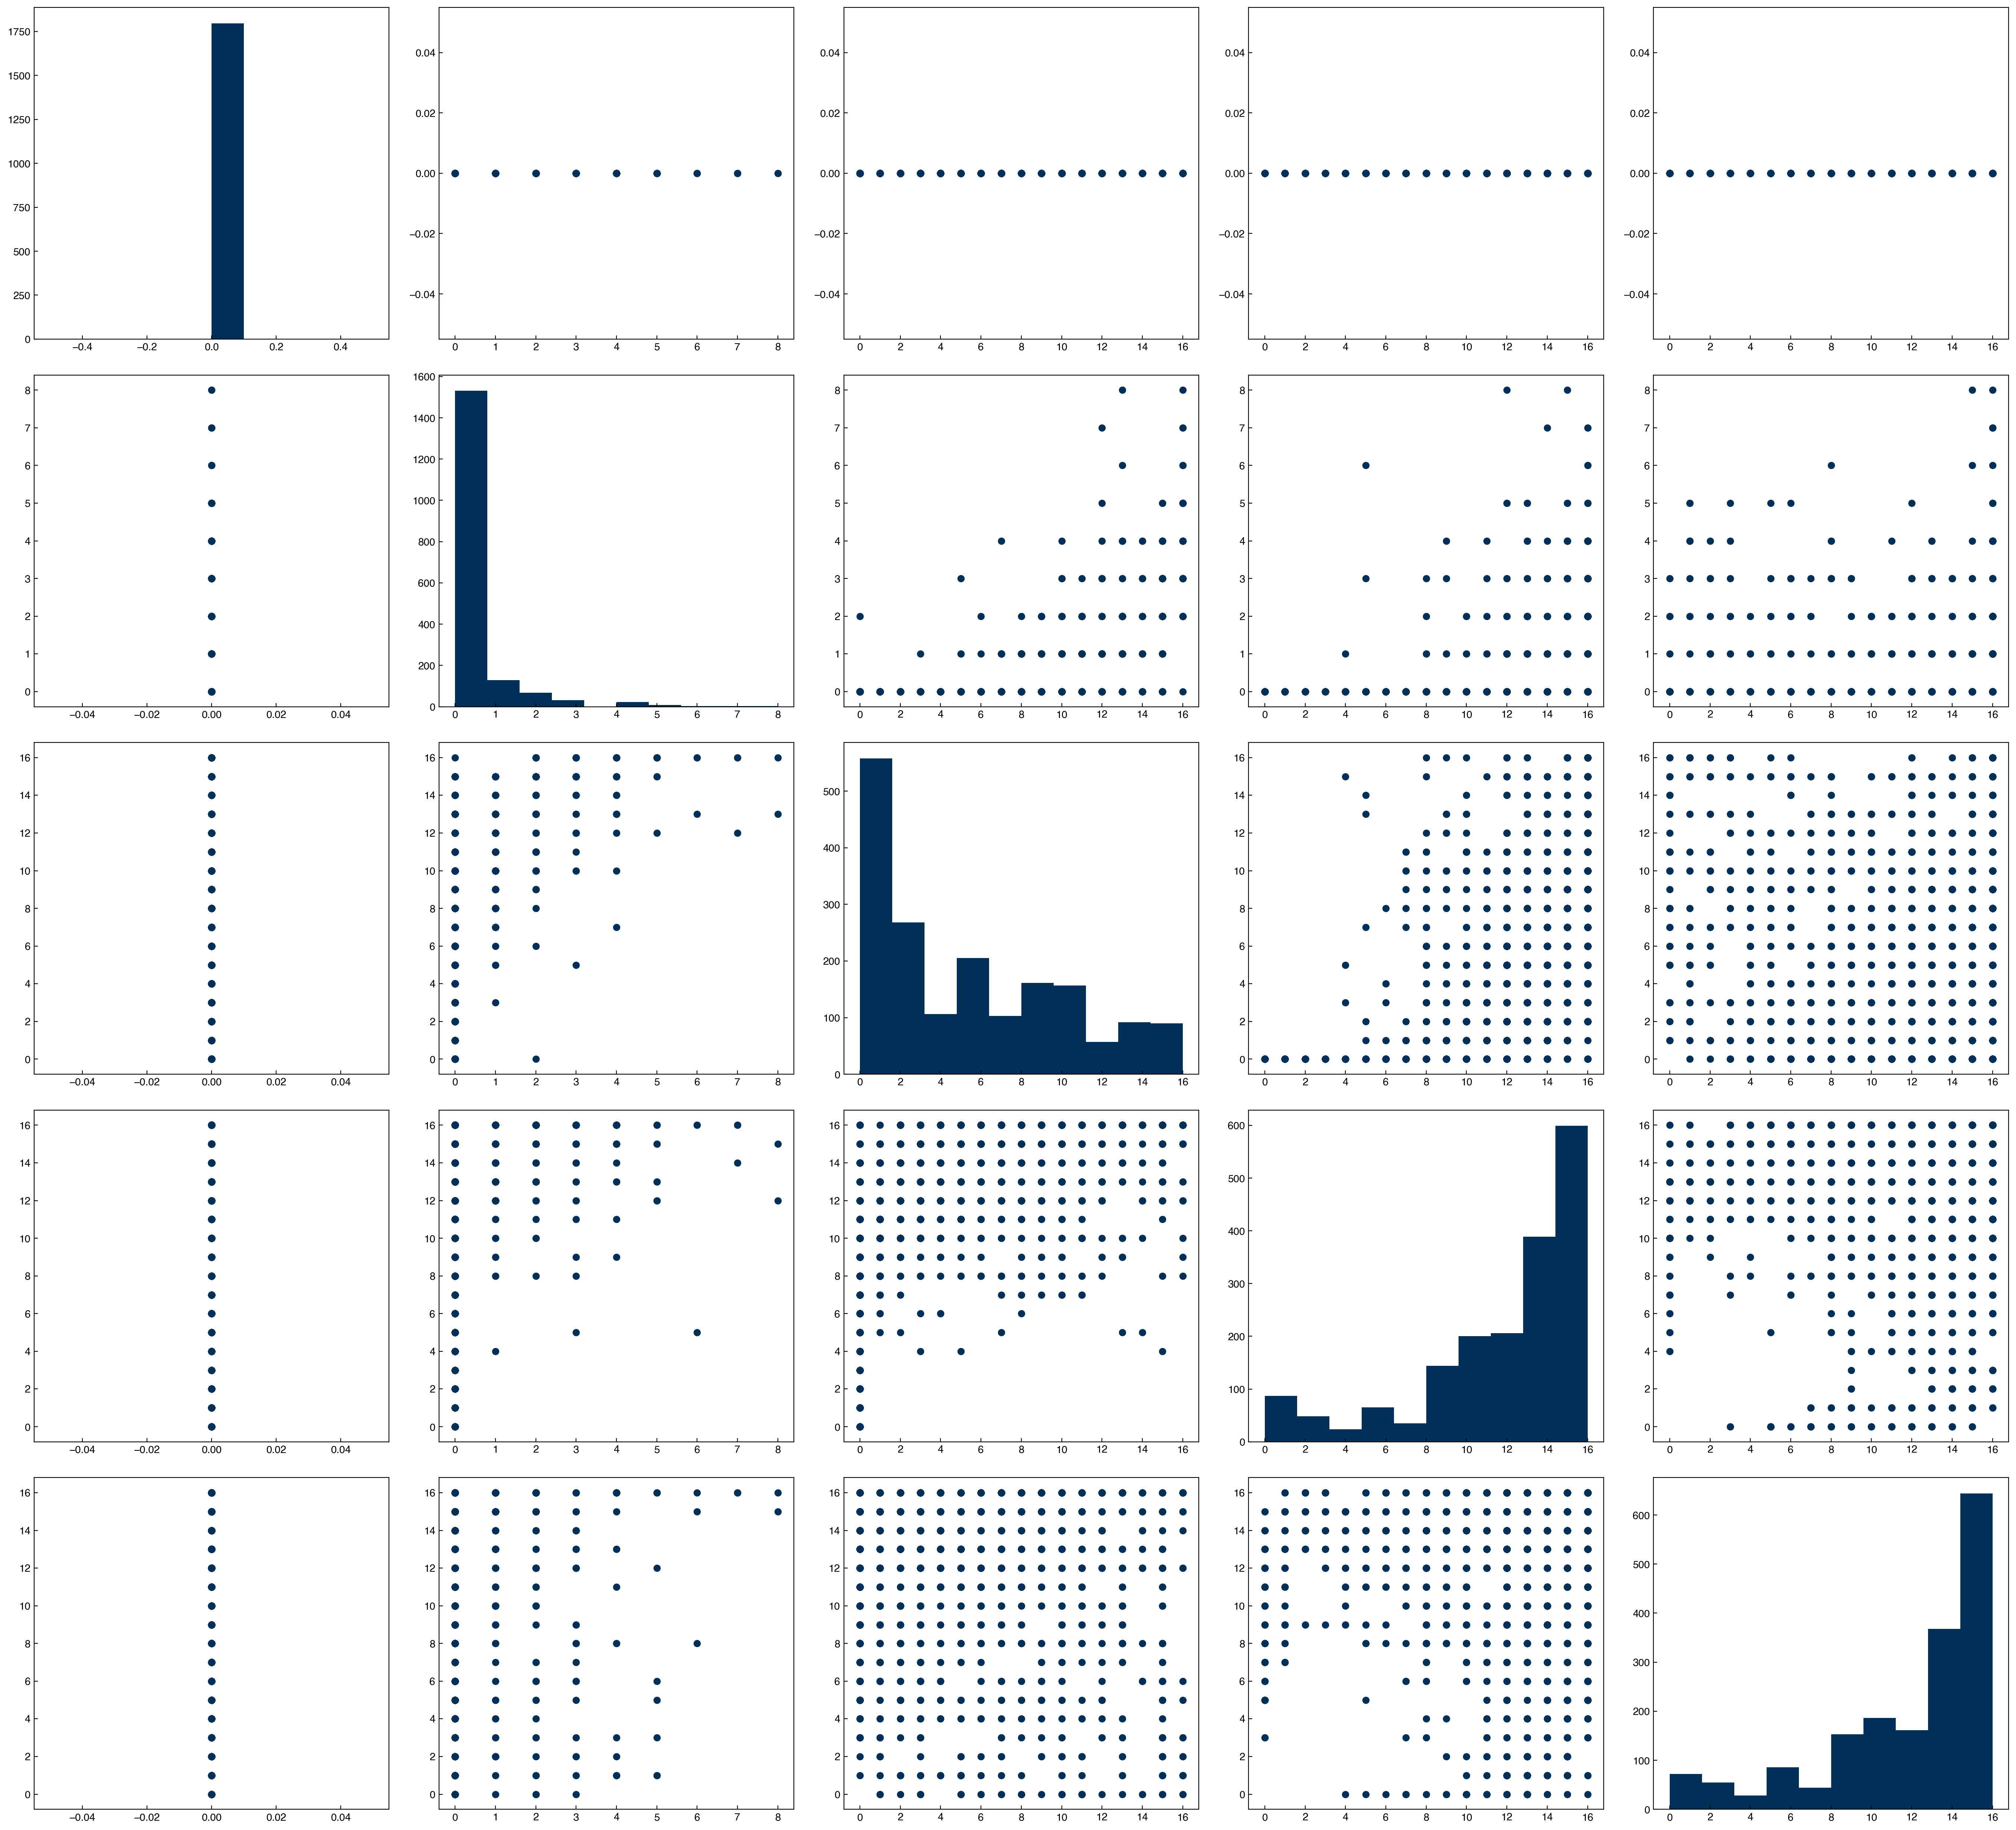

In [14]:
features = [0, 1, 2, 3, 4]
n  = len(features)
fig, axes = plt.subplots(n, n, figsize = (5.5 * n, 5 * n), dpi = 200)

for i in features:
    for j in features:
        ax = axes[i, j]
        if i == j:
            ax.hist(X_mnist[:, i])
        else:
            x = X_mnist[:, j]
            y = X_mnist[:, i]
            ax.scatter(x, y)

By plotting histograms along the diagonal it makes the plot matrix even more meaningful, since we get both single-feature (along diagonal) and dual feature (off-diagonal) information. The `seaborn` library also has a function that makes this even easier:

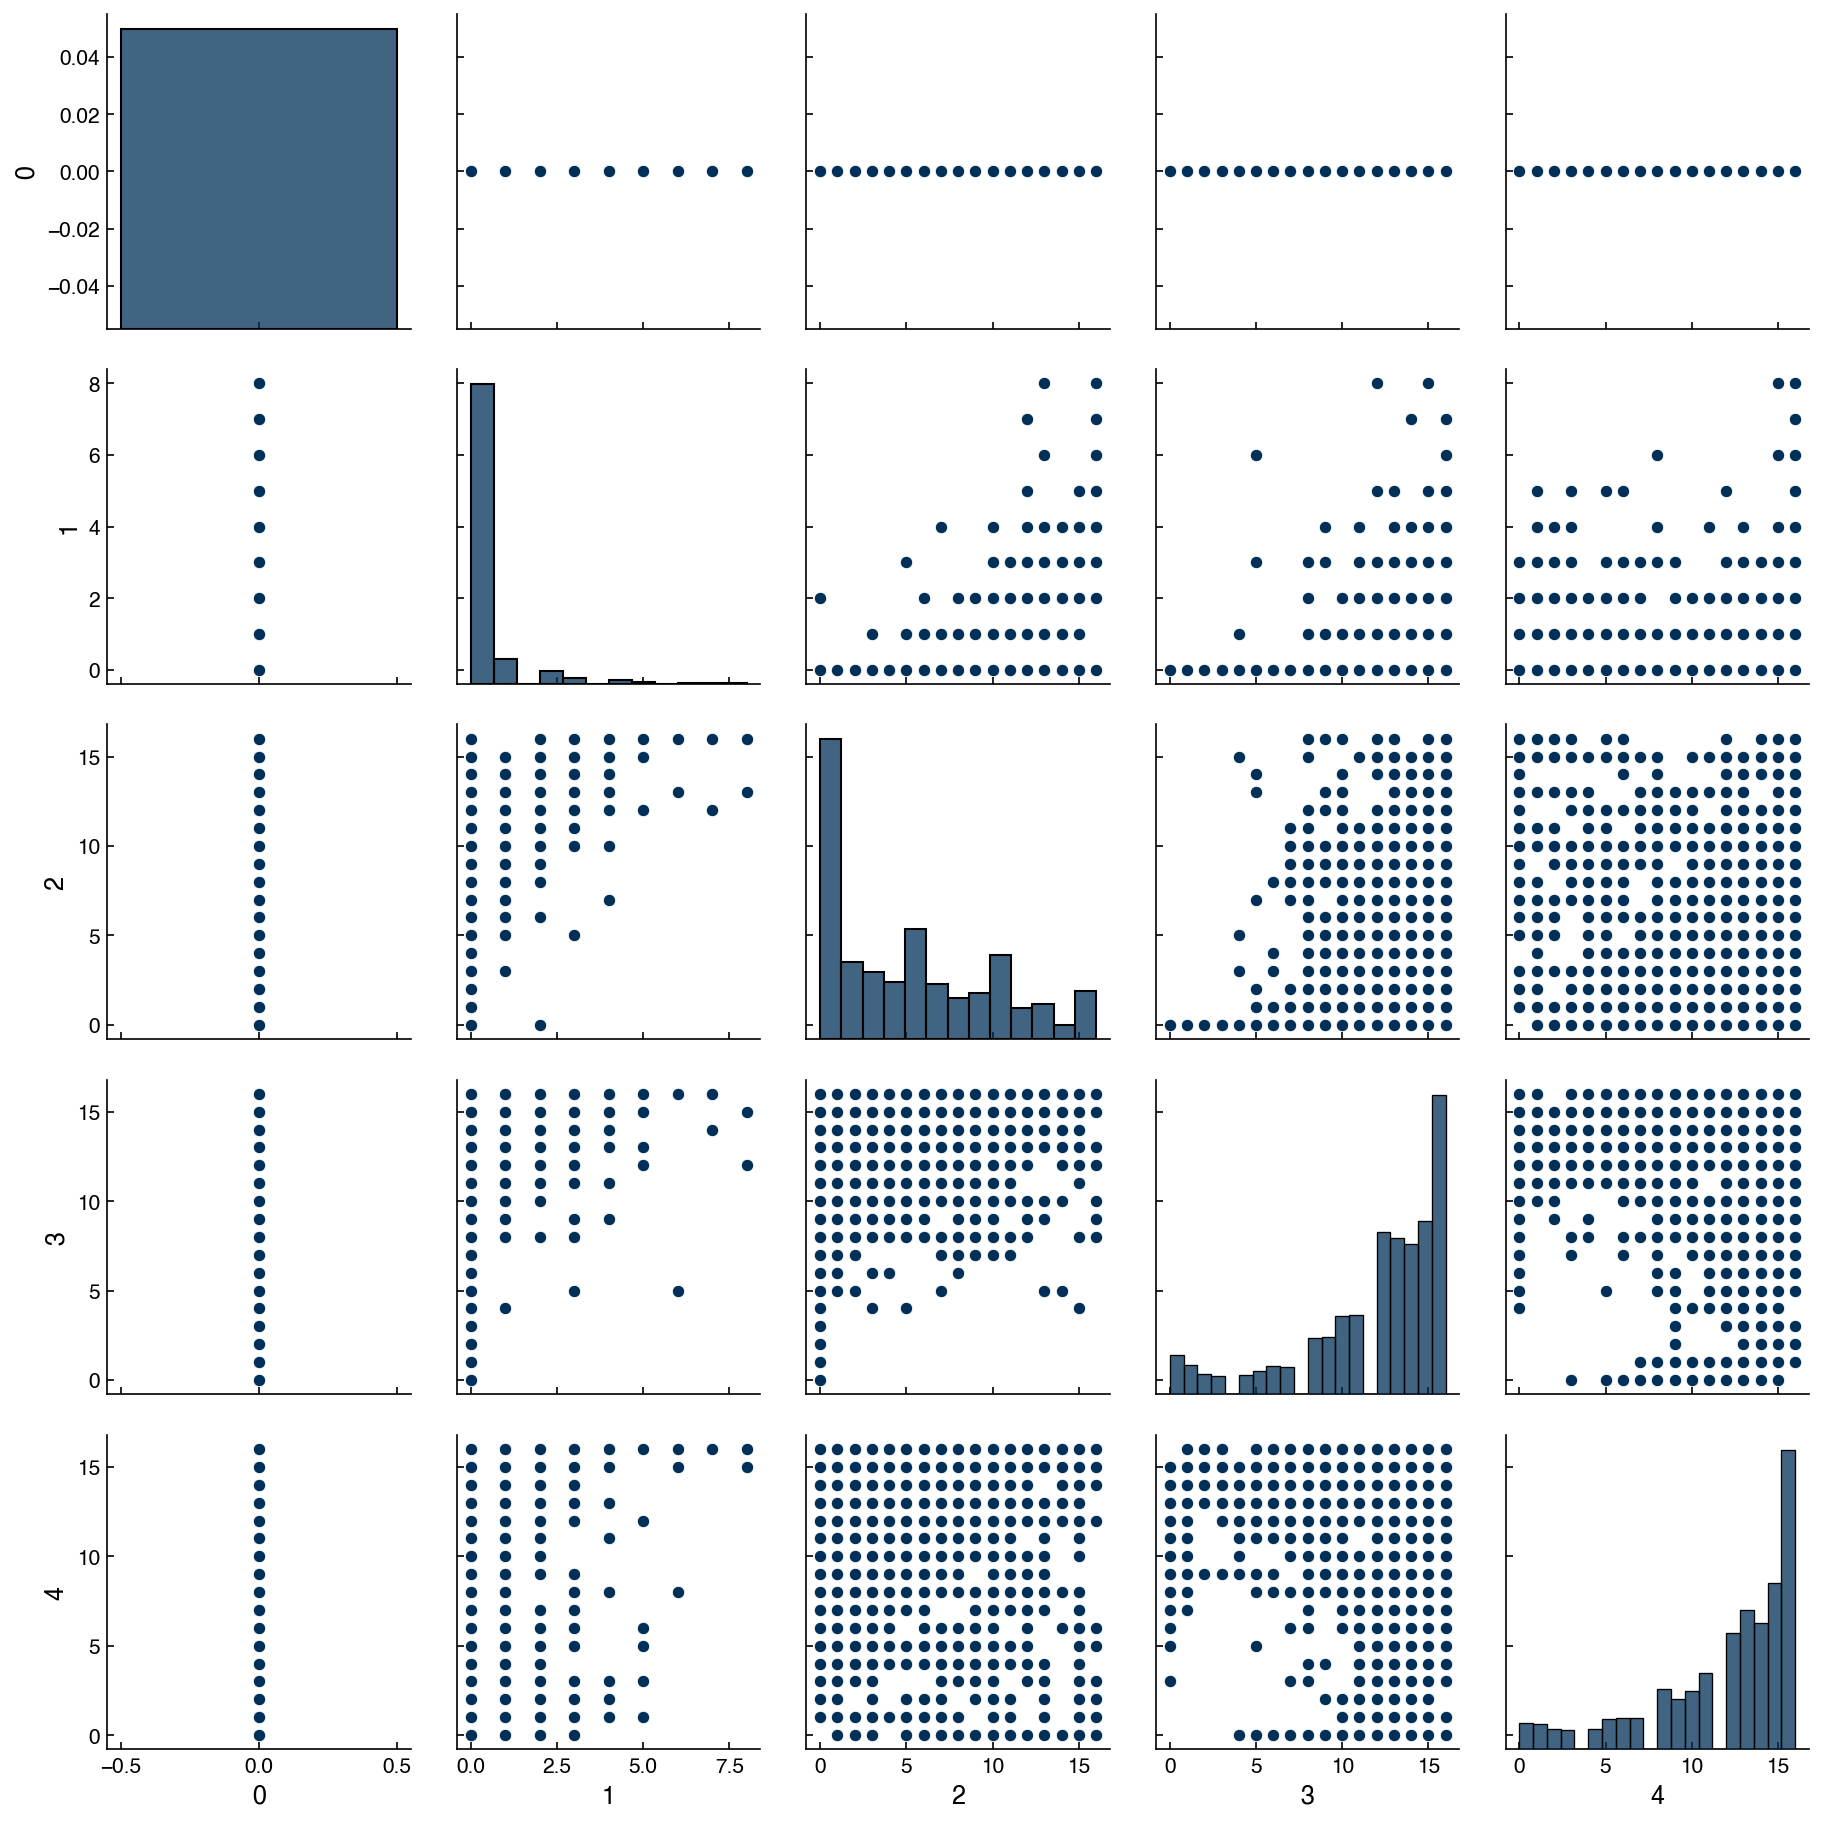

In [15]:
import seaborn as sns

mnist_df = pd.DataFrame(X_mnist)
sns.pairplot(mnist_df[features]);

We see that we first need to convert the array to a dataframe to use the plotting feature. In practice, the data will often already be in a dataframe format, so this is even more convenient.

### Discussion: What does a vertical/horizontal line mean in these plots?
> One of features only has a single value.

We can also make scatter plots for the Dow data to see how they look for continuous features.

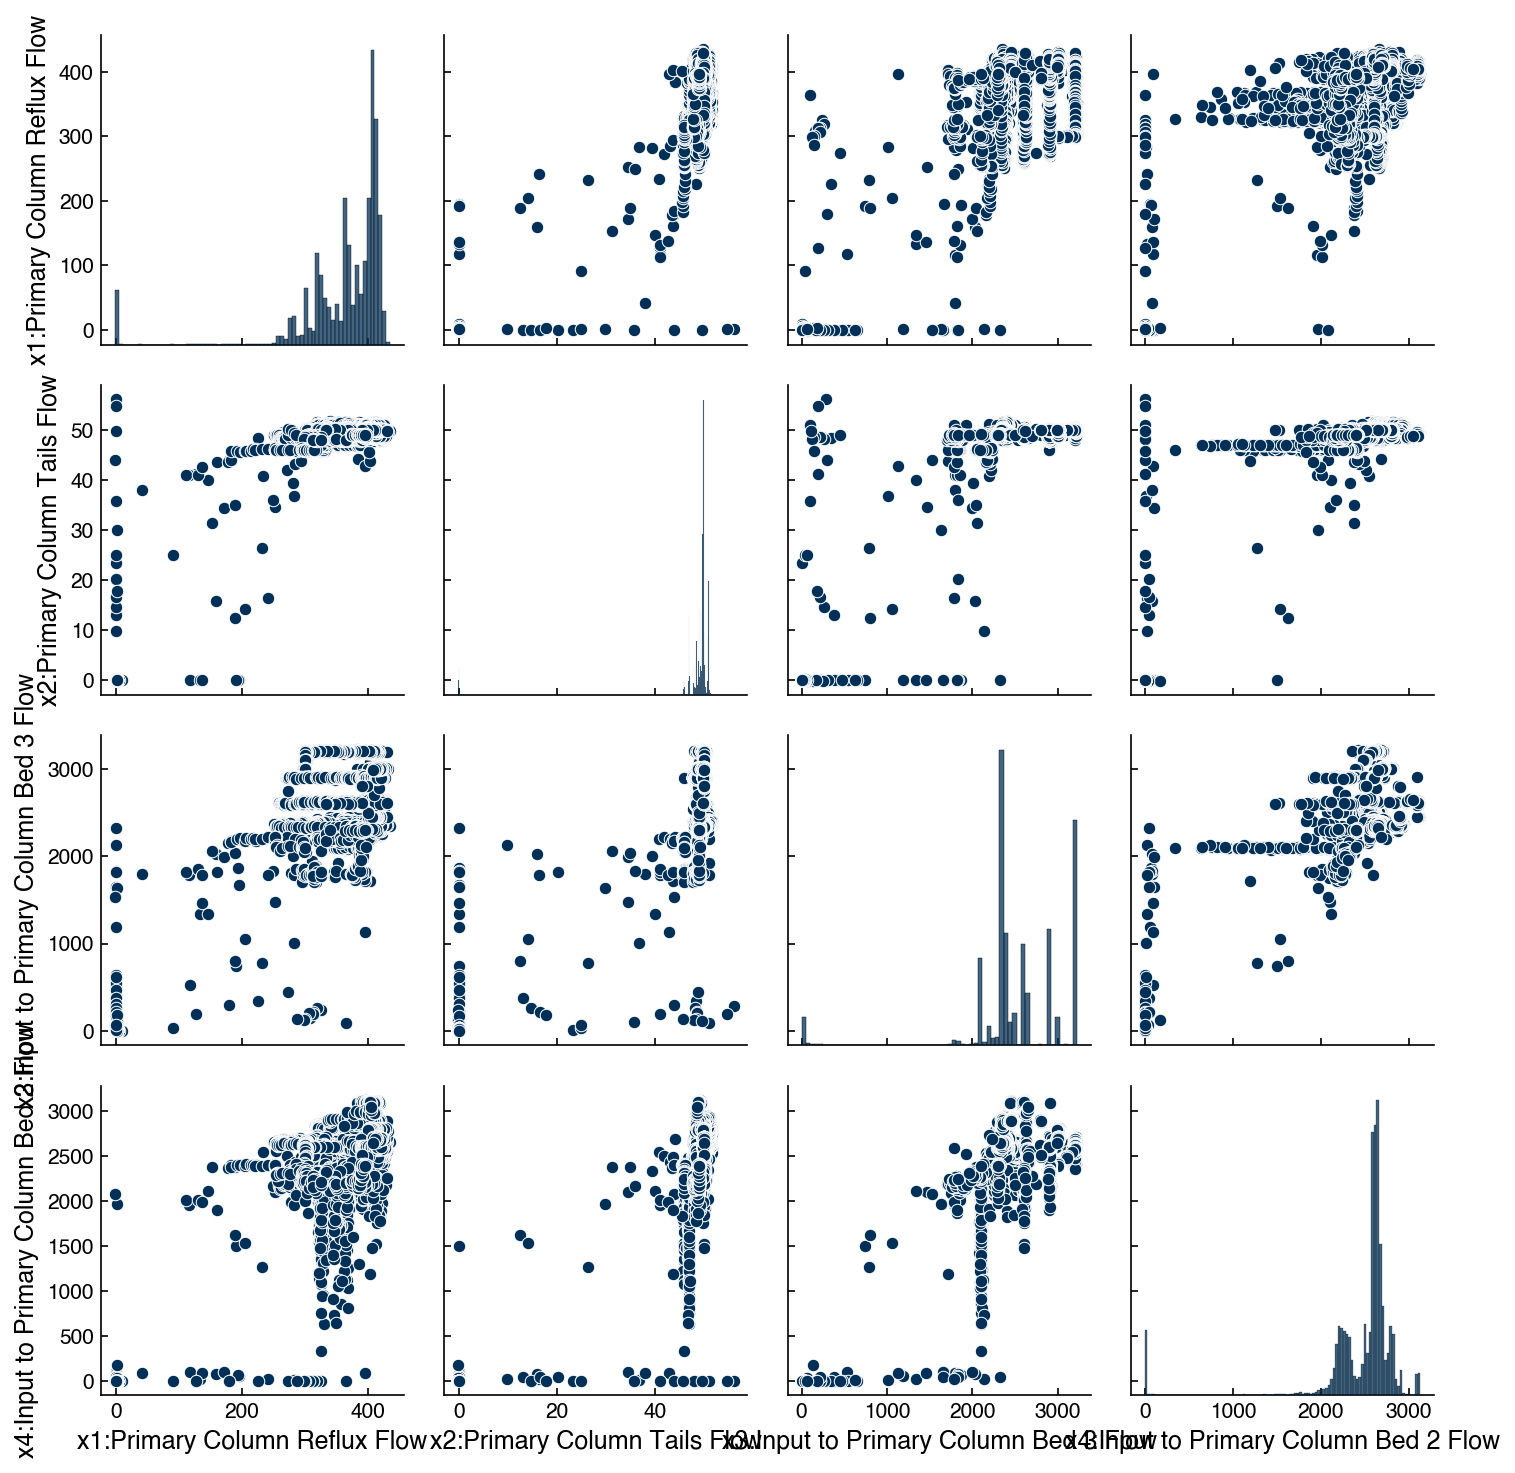

In [16]:
df_dow_clean = df[real_rows]
include_columns = df_dow_clean.columns[1:5]
sns.pairplot(df_dow_clean[include_columns])
plt.tight_layout()

Note this is a bit slower, since there are ~10K data points, so we have only selected 4 features.

### Joint Plots

Sometimes it is also useful to "zoom in" on a given set of variables to get a better feeling for how the features are related. This can be achieved with "joint plots" that show the scatter plot along with the correlation and the distributions. Again, `seaborn` has some nice built-in functionality for this. Let's take a closer look at the relationship between `x3` and `x4` in the Dow dataset:

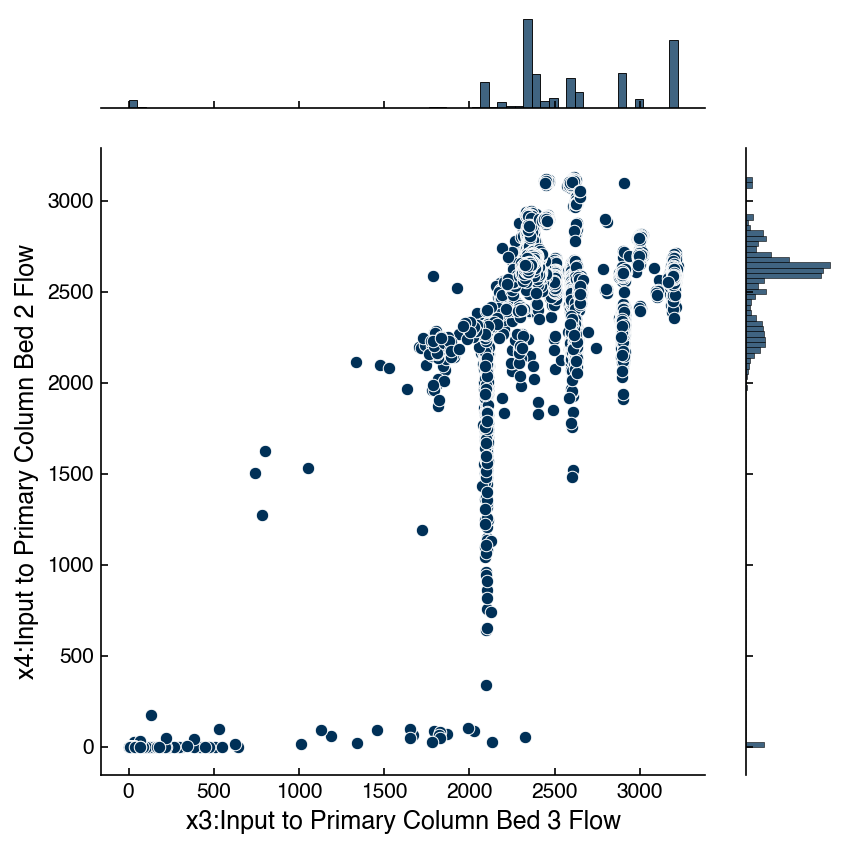

In [17]:
x_col = df_dow_clean.columns[3]
y_col = df_dow_clean.columns[4]
jp = sns.jointplot(x = x_col, y = y_col, data = df_dow_clean)

There are lots of options that can be used to get more insight. In particular the `kind="reg"` option provides the correlation between the variables:

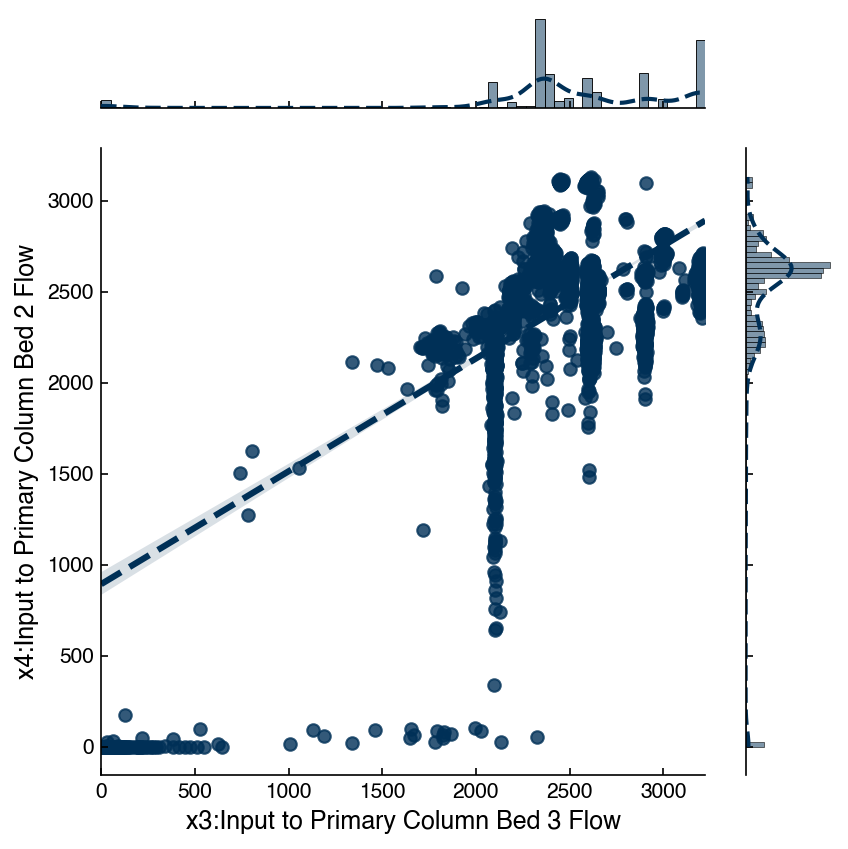

In [18]:
jp = sns.jointplot(x = x_col, y = y_col, data = df_dow_clean, kind = 'reg')

You can read up on the other options in the [seaborn documentation](https://seaborn.pydata.org/generated/seaborn.jointplot.html).

### Correlation Matrix

We discussed the correlation matrix earlier, but this is a good time to revisit it. We can think of the correlation matrix as "zooming out" from the scatter plot matrix. We can compute the correlation matrix with `numpy`. Let's take a look at variables 2-10 of the MNIST dataset (we are avoiding features with vertical/horizontal lines):

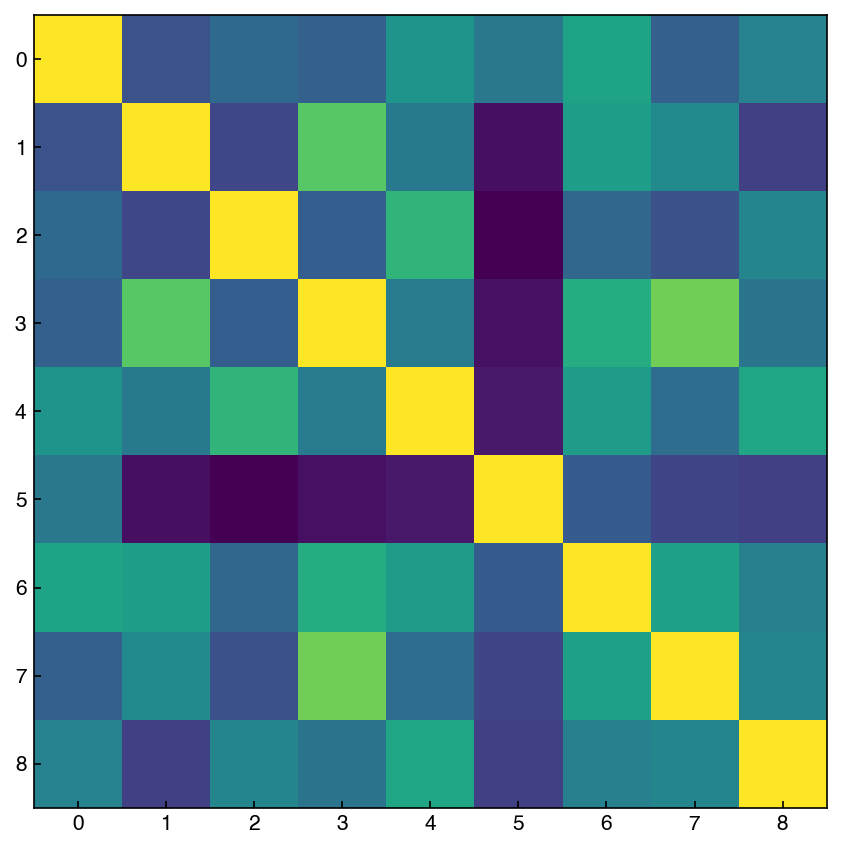

In [19]:
features = range(2, 11)
X_reduced = X_mnist[features] # select first 10 features
corr_mnist = np.corrcoef(X_reduced)

fig, ax = plt.subplots()
ax.imshow(corr_mnist);

There is also a useful tool in `seaborn` for creating an easier-to-read correlation matrix:

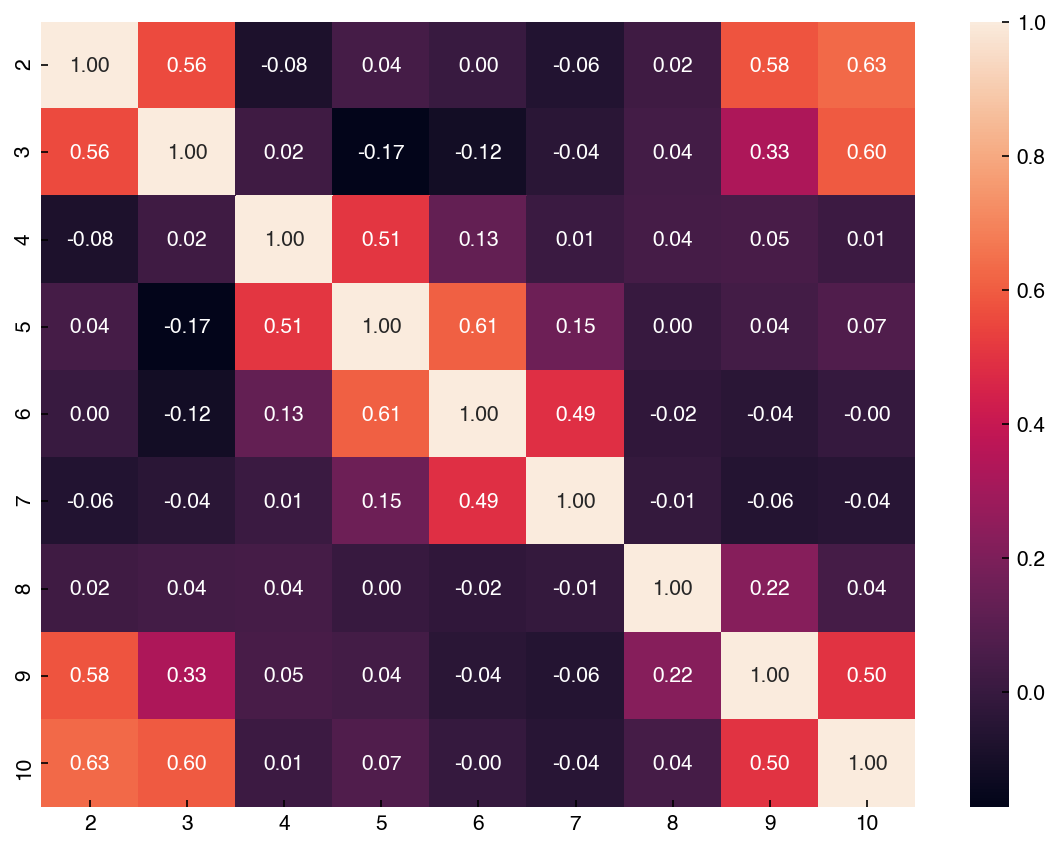

In [20]:
corr = mnist_df[features].corr()
hm = sns.heatmap(corr, annot = True, fmt = '.2f', annot_kws = {'fontsize': 10})

Unlike the scatter plot matrix, the correlation matrix is a bit easier to compute and visualize for a larger number of dimensions. Let's take a look at the full MNIST dataset:

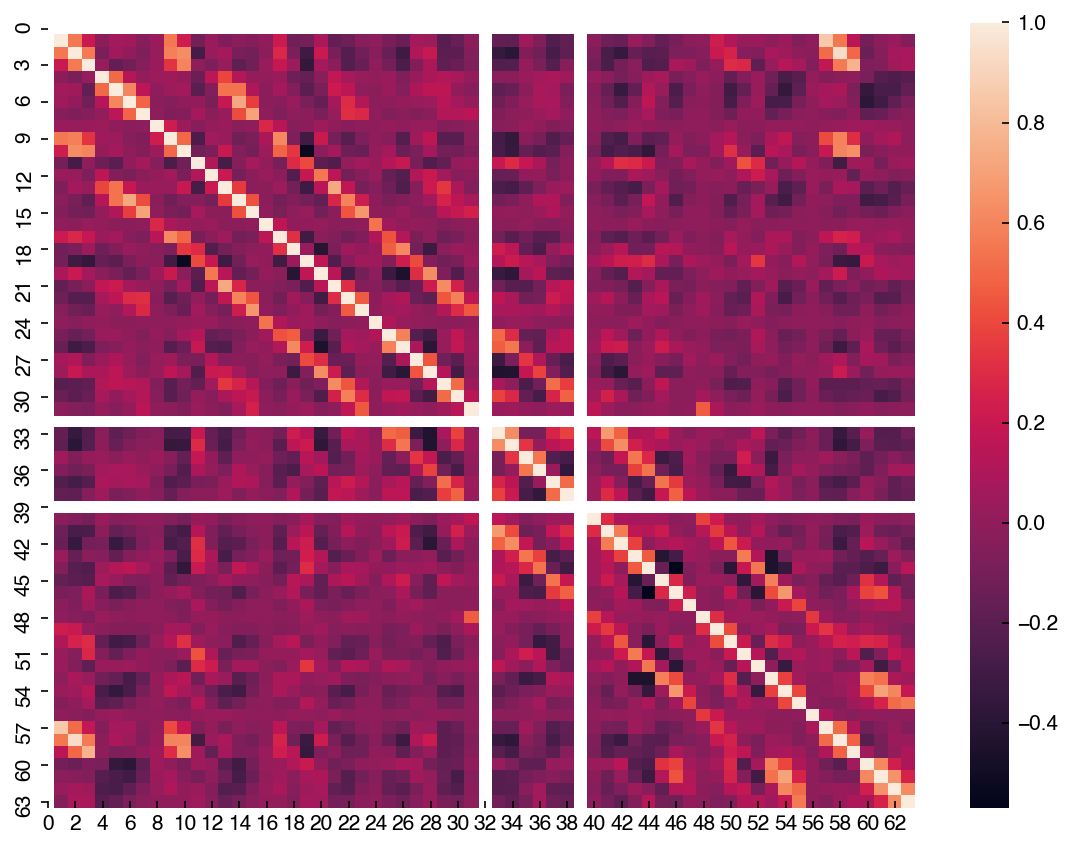

In [21]:
corr = mnist_df.corr()
hm = sns.heatmap(corr)

The labels are especially helpful when dealing with datasets where the features have names. Let's look at the correlation matrix for the first 4 features of the Dow dataset:

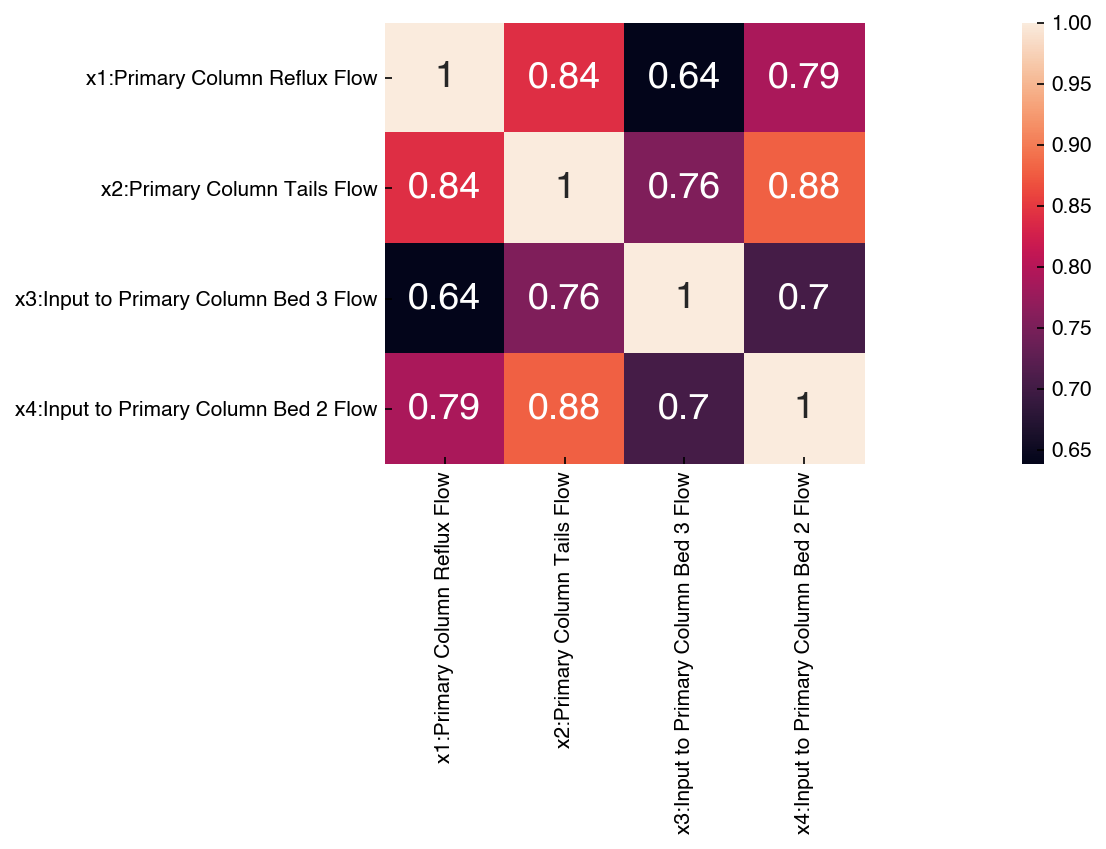

In [22]:
corr_dow = df_dow_clean[include_columns].corr()
hm = sns.heatmap(corr_dow, annot=True)
hm.set_xlim([0,5]);

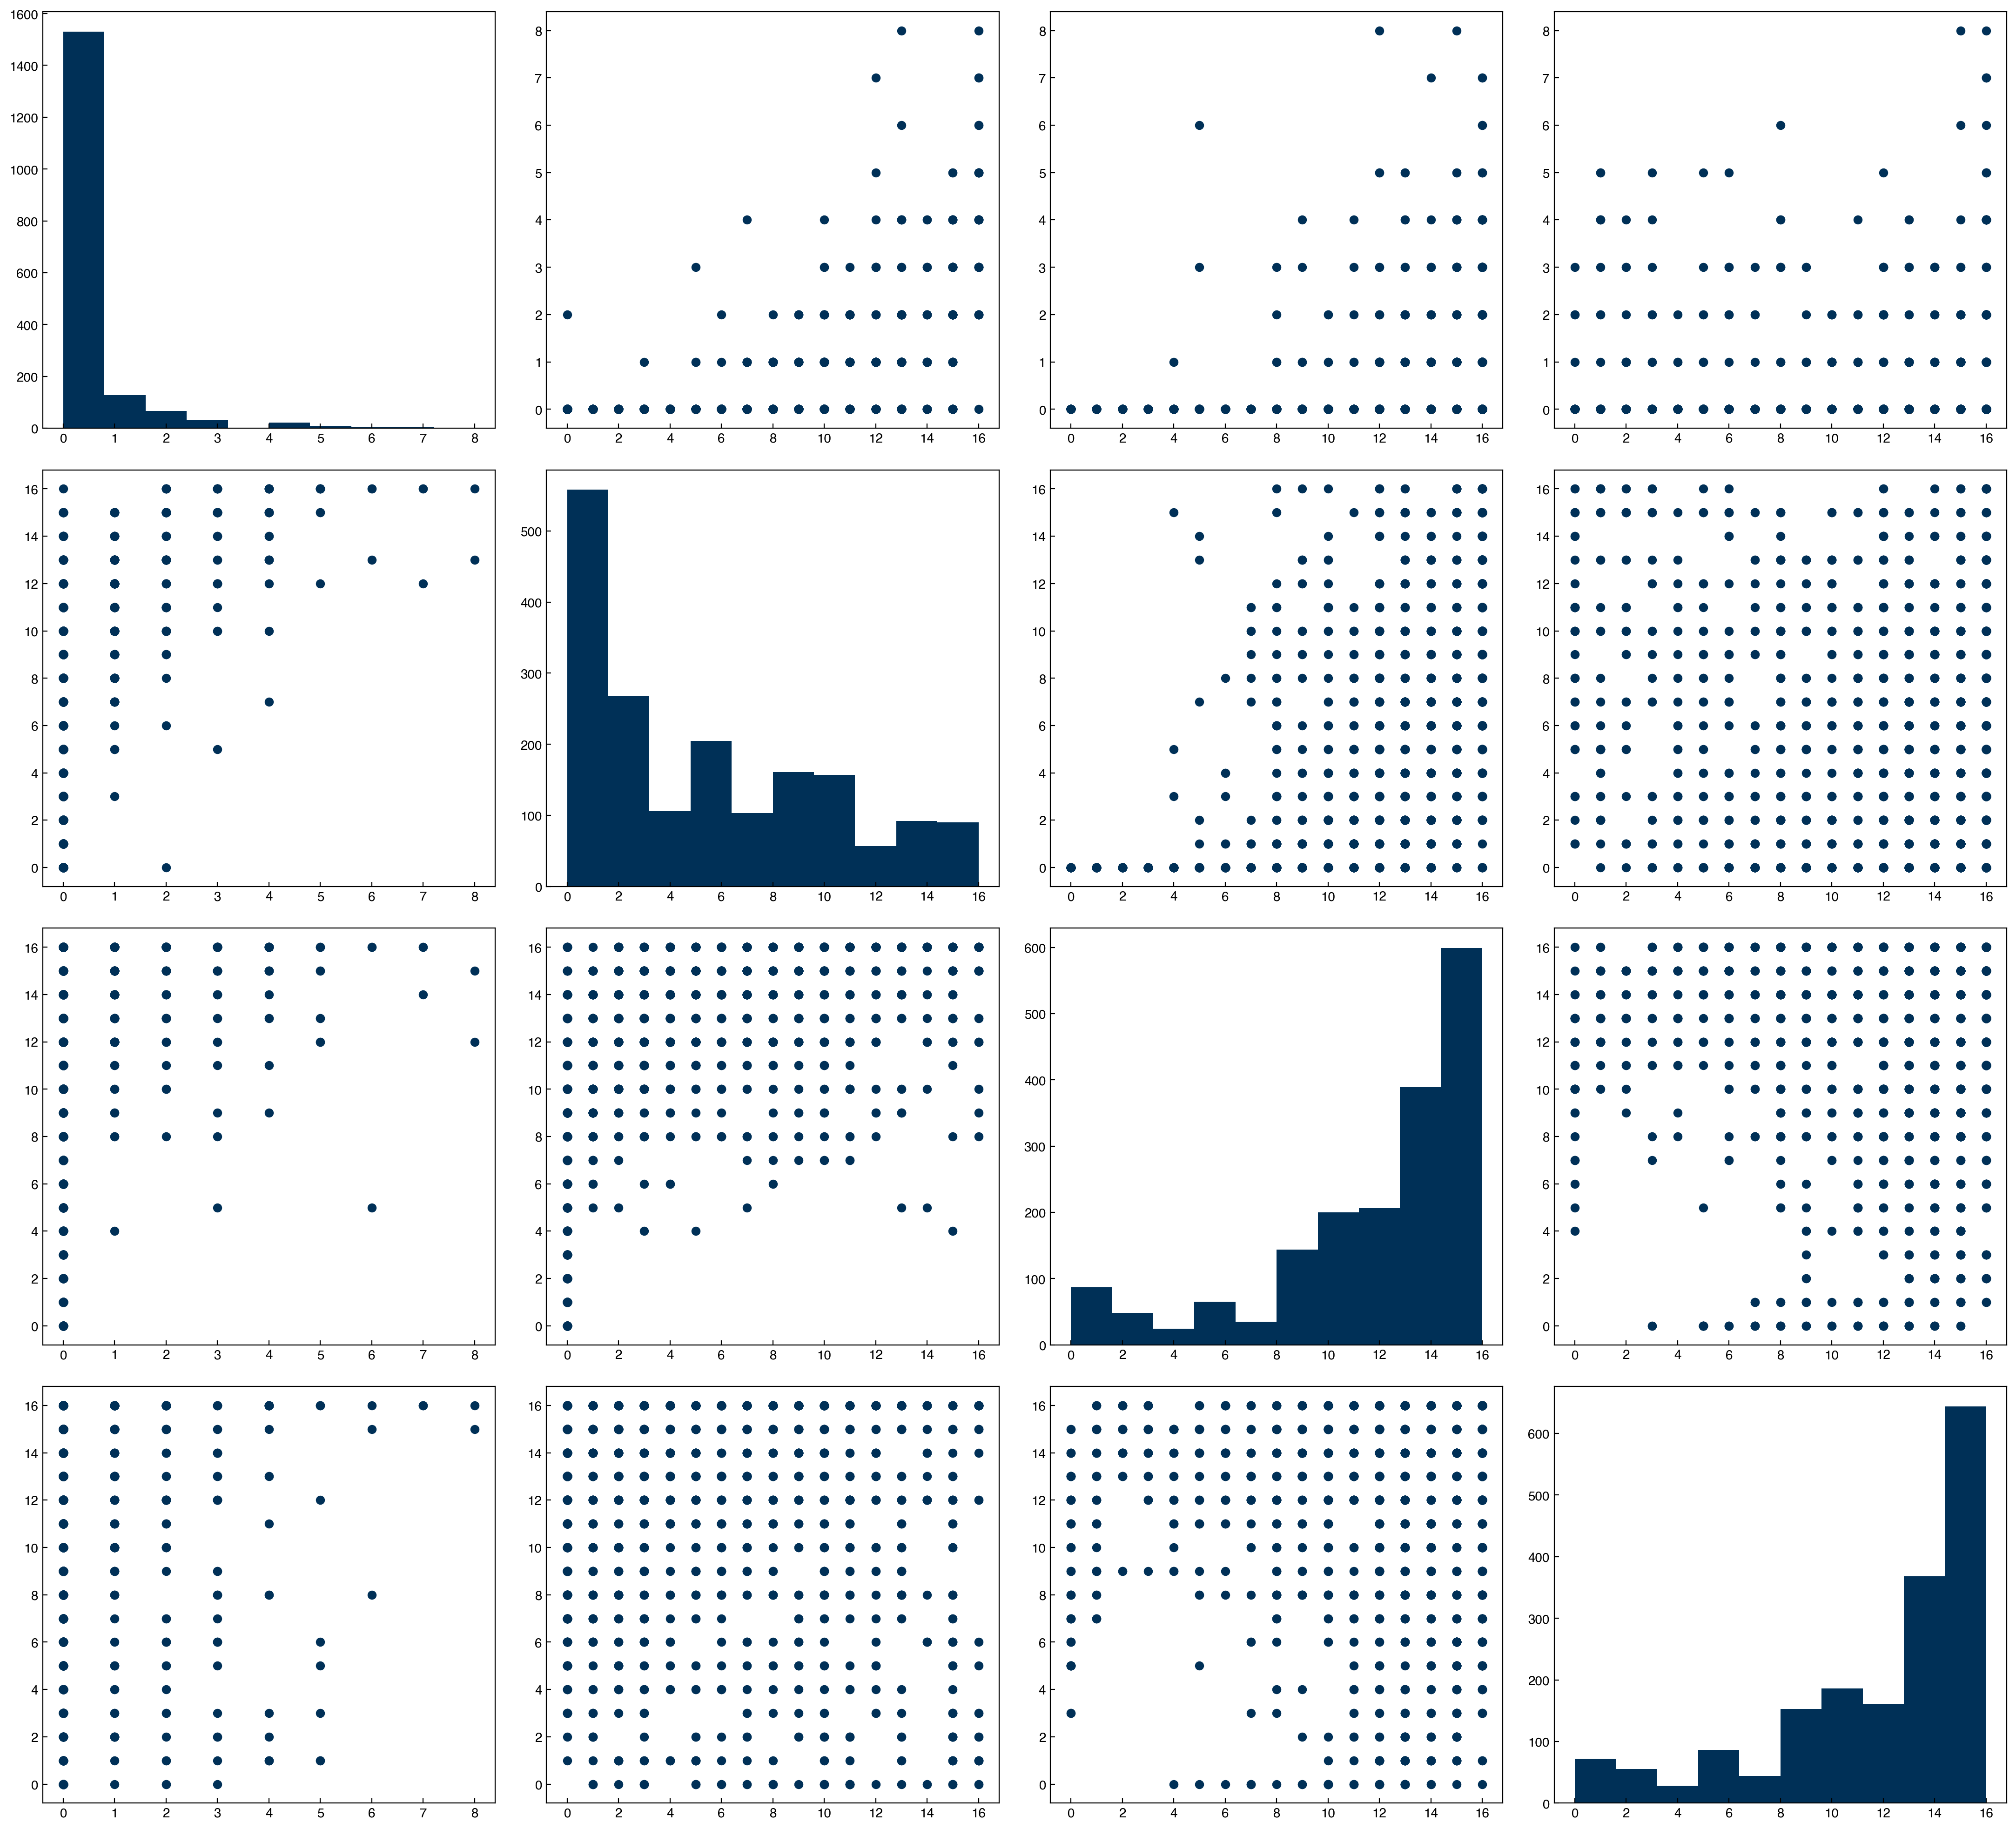

In [23]:
features = [1, 2, 3, 4]
n  = len(features)
fig, axes = plt.subplots(n, n, figsize = (5.5 * n, 5 * n), dpi = 200)

for i in features:
    for j in features:
        ax = axes[i - 1, j - 1]
        if i == j:
            ax.hist(X_mnist[:, i])
        else:
            x = X_mnist[:, j]
            y = X_mnist[:, i]
            ax.scatter(x, y)

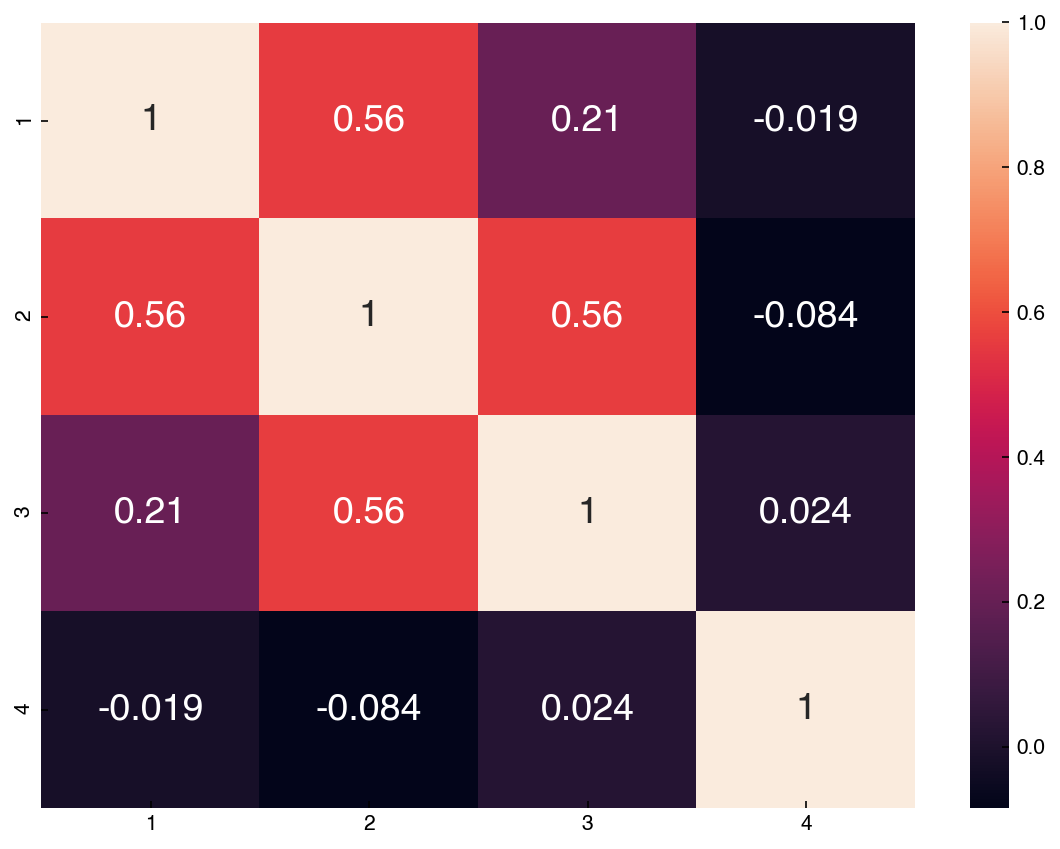

In [24]:
corr = mnist_df[features].corr()
hm = sns.heatmap(corr, annot = True)

Compare this to the scatter plot matrix. You can see that features with high correlations have scatter plots that are more aligned. One way to interpret this correlation matrix is as the slope of a regression line between any two features after the features have been standardized (mean = 0, stdev = 1).